In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
train = pd.read_csv('train.csv')
org = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

train = pd.concat([train, org])

test = pd.read_csv('test.csv')
ids = test['id']
df = pd.concat([train, test])

In [89]:
df = df.drop(columns = ['id', 'EmployeeNumber'])

In [91]:
df['Attrition'] = df['Attrition'].map({1:1, 0:0, 'Yes': 1, 'No': 0})
df['Over18'] = df['Over18'].map({'Y': 1, 'N': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

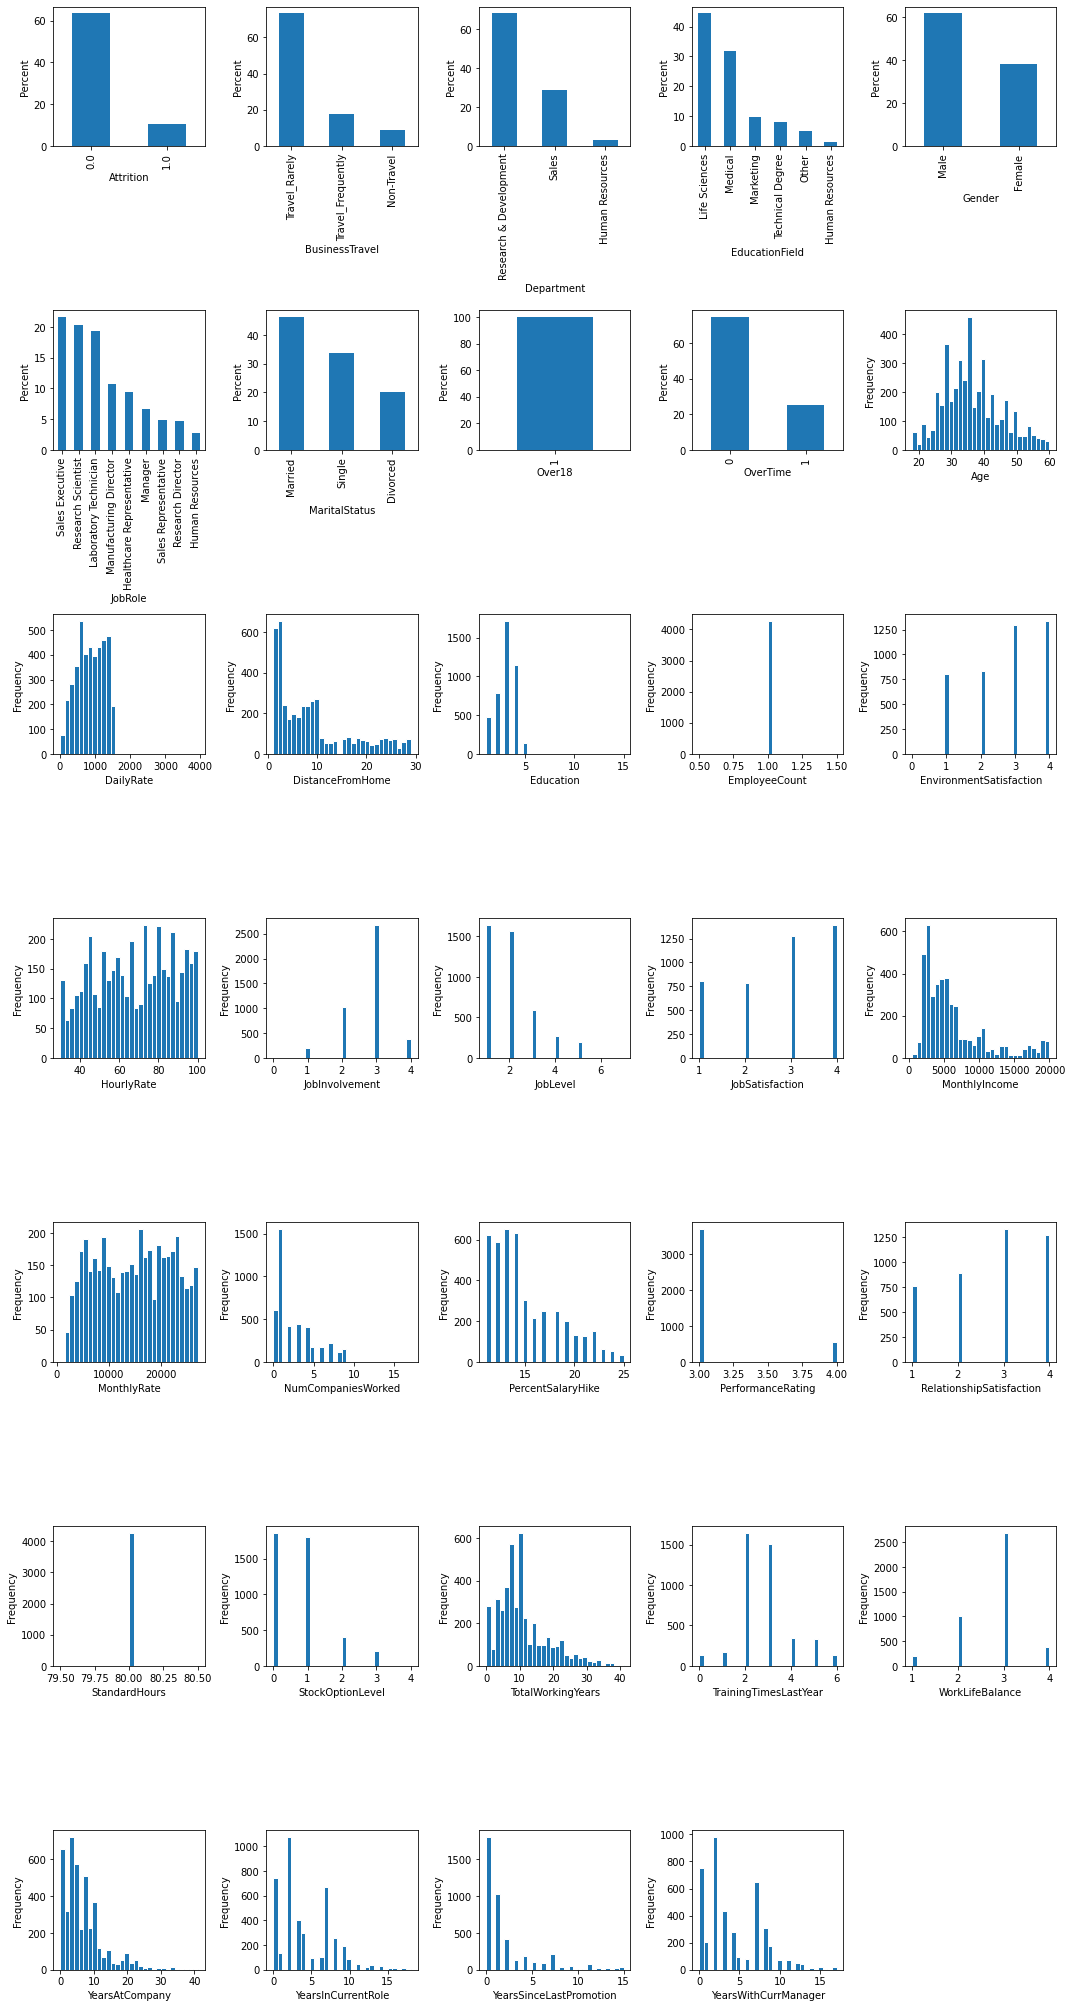

In [96]:
categorical = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
               'MaritalStatus', 'Over18', 'OverTime']
numerical = df.drop(columns = categorical).columns

fig, axes = plt.subplots(7, 5, figsize=(15, 28))
axes = axes.flatten()

for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df[col].plot.hist(ax = axes[j], bins = 30, edgecolor='white')
    axes[j].set_xlabel(col)
    
for ax in axes[j+1:]:
    ax.axis('off')
    
plt.tight_layout()

In [97]:
df_dummy = pd.get_dummies(df)

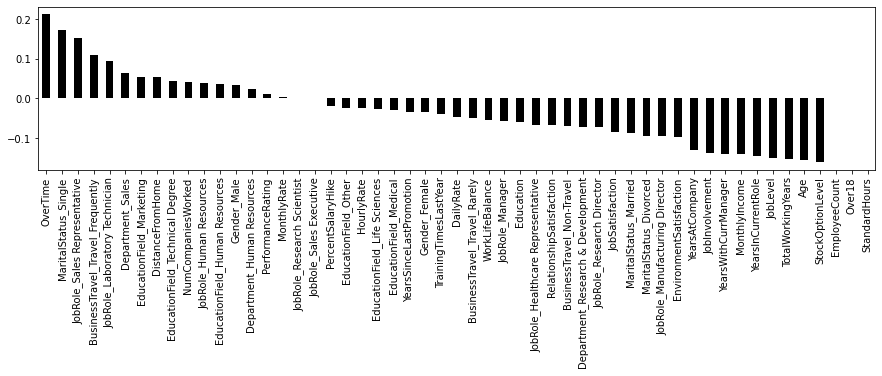

In [98]:
df_dummy.corr()['Attrition'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [100]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns='Attrition')
y = df_dummy['Attrition']

features = X.columns.values

Scaler = MinMaxScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

X_test = X.iloc[len(train):]
X = X.iloc[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [101]:
%%time
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict_proba(X_train)[:, 1]
y_valid_pred = model_lr.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.8560621291109755
Validation score:  0.8378921441534871
CPU times: user 161 ms, sys: 92.8 ms, total: 254 ms
Wall time: 106 ms


In [102]:
%%time
model = XGBClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:, 1]
y_valid_pred = model.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  1.0
Validation score:  0.8346235045742435
CPU times: user 1.69 s, sys: 26.8 ms, total: 1.71 s
Wall time: 480 ms


In [103]:
final_model = XGBClassifier()
final_model.fit(X, y)
print("Training score: ", metrics.roc_auc_score(y, final_model.predict_proba(X)[:, 1]))
y_test_pred = final_model.predict_proba(X_test)[:, -1]

Training score:  1.0


In [104]:
output = pd.DataFrame({'id': ids, 'Attrition': y_test_pred})

In [105]:
output.to_csv("Submission.csv", index=False)